# Diabetes classification

Reference: https://www.analyticsvidhya.com/blog/2021/06/classification-problem-relation-between-sensitivity-specificity-and-accuracy/

In [89]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

## Load data

In [90]:
# Data from kaggle (https://www.kaggle.com/datasets/julnazz/diabetes-health-indicators-dataset?resource=download&select=diabetes_binary_5050split_health_indicators_BRFSS2021.csv)
df = pd.read_csv('data/diabetes_binary_health_indicators_BRFSS2021.csv')

In [91]:
df.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

## Assign independent & dependent variables

In [92]:
X = df['BMI'] # Independent variable: body mass index
y = df['Diabetes_binary'] # Dependent variable: diabetes (1: yes, 0: no)

## Split into train/test

In [93]:
# Split into training and testing (70%;30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

## Fit GLM

In [94]:
# Add column of 1s to account for intercept in regression
X_train_sm = sm.add_constant(X_train)

In [95]:
# Generalized linear model regression
logm2 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()) # Binomial b/c either yes/no diabetes
res = logm2.fit()
res.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Diabetes_binary   No. Observations:               165464
Model:                            GLM   Df Residuals:                   165462
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64476.
Date:                Sat, 06 Jan 2024   Deviance:                   1.2895e+05
Time:                        14:52:31   Pearson chi2:                 1.62e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03508
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0813      0.032   -129.438      0.000      -4.143      -4.019
BMI            0.0757      0.001     76.722      0.000       0.074       0.078
==============================================================================
"""

In [96]:
# Predict probability of yes/no
y_train_pred = res.predict(X_train_sm)

In [97]:
# Create training df
train_dict = {'BMI':X_train, 'Diabetes':y_train, 'y_train_pred':y_train_pred}
train_df = pd.DataFrame(train_dict)

## Create cutoff threshold for classification

In [98]:
cut_off = 0.5 # arbitrarily start with 50%
train_df['Diabetes_predicted'] = train_df.y_train_pred.map(lambda x: 1 if x > cut_off else 0)
train_df.head()

,BMI,Diabetes,y_train_pred,Diabetes_predicted
153394,36.0,0.0,0.204672,0
15877,27.0,1.0,0.115237,0
128811,29.0,1.0,0.131587,0
152335,24.0,0.0,0.094036,0
16031,35.0,0.0,0.192630,0


### Calculate confusion matrix

In [99]:
confusion = metrics.confusion_matrix(train_df.Diabetes, train_df.Diabetes_predicted)
print(confusion)

[[141520    545]
 [ 23103    296]]


In [100]:
print(metrics.accuracy_score(train_df.Diabetes, train_df.Diabetes_predicted))

0.8570806942899967


## Try different cutoff thresholds 

In [101]:
numbers = [float(x)/10 for x in range(10)] # 0.1 - 0.9
# Create new cols indicating yes/no diabetes based on thresholds
for i in numbers:
    train_df[i]= train_df.y_train_pred.map(lambda x: 1 if x > i else 0)
train_df.head()

,BMI,Diabetes,y_train_pred,Diabetes_predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
153394,36.0,0.0,0.204672,0,1,1,1,0,0,0,0,0,0,0
15877,27.0,1.0,0.115237,0,1,1,0,0,0,0,0,0,0,0
128811,29.0,1.0,0.131587,0,1,1,0,0,0,0,0,0,0,0
152335,24.0,0.0,0.094036,0,1,0,0,0,0,0,0,0,0,0
16031,35.0,0.0,0.192630,0,1,1,0,0,0,0,0,0,0,0


In [102]:
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives
cutoff_df = pd.DataFrame( columns = ['Probability','Accuracy','Sensitivity','Specificity'])

for i in numbers:
    cm1 = metrics.confusion_matrix(train_df.Diabetes, train_df[i])
    total1=sum(sum(cm1))
    Accuracy = (cm1[0,0]+cm1[1,1])/total1
    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,Accuracy,Sensitivity,Specificity]
# # Let's plot accuracy sensitivity and specificity for various probabilities.


In [103]:
cutoff_df

,Probability,Accuracy,Sensitivity,Specificity
0.0,0.0,0.141414,1.000000,0.000000
0.1,0.1,0.364478,0.888500,0.278168
0.2,0.2,0.795001,0.266934,0.881977
0.3,0.3,0.844589,0.088978,0.969042
0.4,0.4,0.854458,0.031497,0.990005
0.5,0.5,0.857081,0.012650,0.996164
0.6,0.6,0.857878,0.004787,0.998388
0.7,0.7,0.858314,0.002051,0.999345
0.8,0.8,0.858362,0.000769,0.999613
0.9,0.9,0.858549,0.000385,0.999894


### Plot sensitivity, specificity, and accuracy with increasing probability thresholds 

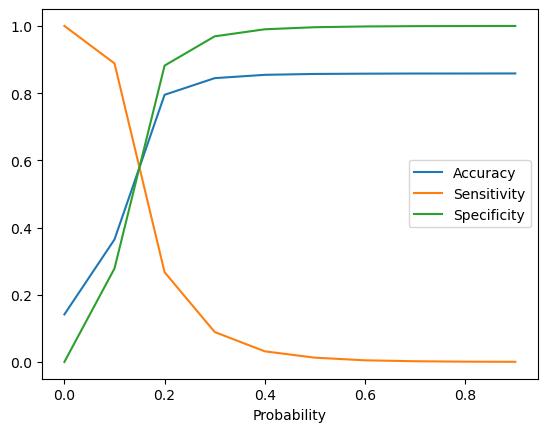

In [104]:
plt.plot(cutoff_df[['Accuracy', 'Sensitivity', 'Specificity']], label=['Accuracy', 'Sensitivity', 'Specificity'])
plt.legend()
plt.xlabel('Probability')
plt.show()

Based on the plot, the sensitivity and specificity seem to cross at around 0.17 

In [105]:
cut_off = 0.17
train_df['Diabetes_predicted'] = train_df.y_train_pred.map(lambda x: 1 if x > cut_off else 0)
# Let's check the overall accuracy.
print(metrics.accuracy_score(train_df.Diabetes, train_df.Diabetes_predicted))

0.7401489145675192


In [106]:
confusion = metrics.confusion_matrix(train_df.Diabetes, train_df.Diabetes_predicted)
print(confusion)

[[112883  29182]
 [ 13814   9585]]


In [107]:
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [108]:
# Let's see the sensitivity of our logistic regression model
print(f"Sensitivity: {TP / float(TP+FN)}")
# Let us calculate specificity
print(f"Specificity: {TN / float(TN+FP)}")

Sensitivity: 0.40963289029445704
Specificity: 0.7945869848308873


## Apply to test data

In [109]:
# Add column of 1s to account for intercept in regression
X_test_sm = sm.add_constant(X_test)

In [110]:
# Predict probability of yes/no
y_test_pred = res.predict(X_test_sm)

In [111]:
# Create test df
test_dict = {'BMI':X_test, 'Diabetes':y_test, 'y_test_pred':y_test_pred}
test_df = pd.DataFrame(test_dict)
test_df.head()

,BMI,Diabetes,y_test_pred
162279,28.0,0.0,0.123179
15102,20.0,0.0,0.071228
79115,30.0,1.0,0.140477
83432,39.0,1.0,0.244097
204427,25.0,0.0,0.100683


In [112]:
cut_off = 0.17 # 17% used based on training data
test_df['Diabetes_predicted'] = test_df.y_test_pred.map(lambda x: 1 if x > cut_off else 0)
test_df.head()

,BMI,Diabetes,y_test_pred,Diabetes_predicted
162279,28.0,0.0,0.123179,0
15102,20.0,0.0,0.071228,0
79115,30.0,1.0,0.140477,0
83432,39.0,1.0,0.244097,1
204427,25.0,0.0,0.100683,0


In [113]:
print(metrics.accuracy_score(test_df.Diabetes, test_df.Diabetes_predicted))

0.7380912090701413


In [114]:
# Confusion matrix 
confusion_test = metrics.confusion_matrix(test_df.Diabetes, test_df.Diabetes_predicted)
print(confusion_test)

[[48204 12541]
 [ 6032  4137]]


In [115]:
TP = confusion_test[1,1] # true positive 
TN = confusion_test[0,0] # true negatives
FP = confusion_test[0,1] # false positives
FN = confusion_test[1,0] # false negatives

In [118]:
# Sensitivity and Specificity of classification
print(f"Sensitivity: {TP / float(TP+FN)}")
print(f"Specificty: {TN / float(TN+FP)}")

Sensitivity: 0.4068246631920543
Specificty: 0.7935467939748128
